In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

import random
from tqdm import tqdm
import time

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import mode


from xgboost import XGBClassifier

!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

RANDOM_STATE = 12 
FOLDS = 5

In [ ]:
def reduce_mem_usage(df, verbose=True):
    '''
    source : https://www.kaggle.com/kartik2khandelwal/who-says-you-can-t-use-knn-for-big-dataset
    '''
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

Loading Train Dataset

In [ ]:
train = pd.read_csv('/content/train_dataset.csv')
train.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7135,1654,CL,D-penicillamine,19581,F,N,N,Y,N,0.300000,279.000000,2.960000,84.000000,1500.800000,99.430000,109.000000,293.000000,10.200000,4.000000
1,7326,41,C,D-penicillamine,22880,F,NaN,N,NaN,N,0.300000,NaN,2.960000,NaN,1835.400000,26.350000,131.000000,308.000000,10.800000,1.000000
2,7254,297,D,NaN,27957,F,N,N,NaN,N,0.300000,328.000000,2.640000,4.000000,NaN,NaN,116.000000,194.000000,10.300000,3.000000
3,3135,1872,C,D-penicillamine,21111,F,NaN,Y,Y,N,0.300000,302.000000,2.020000,49.000000,NaN,26.350000,NaN,NaN,10.500000,4.000000
4,2483,939,CL,D-penicillamine,18061,F,NaN,NaN,NaN,N,0.500000,344.000000,3.110000,91.000000,NaN,104.560000,NaN,306.000000,11.400000,2.000000


In [ ]:
train = reduce_mem_usage(train)

Mem. usage decreased to  0.66 Mb (36.2% reduction)


Loading Test Dataset

In [ ]:
test = pd.read_csv('/content/test_dataset.csv')
test.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,3870,41,C,Placebo,22553,F,N,NaN,N,N,1.400000,247.000000,3.620000,NaN,NaN,108.650000,NaN,169.000000,11.600000
1,3462,1811,C,D-penicillamine,16223,F,N,Y,N,N,0.300000,311.000000,2.800000,92.000000,1748.100000,NaN,129.000000,321.000000,11.500000
2,1632,954,C,D-penicillamine,27100,F,N,N,N,N,0.400000,NaN,3.560000,NaN,NaN,43.520000,NaN,296.000000,10.300000
3,722,1969,D,Placebo,17039,F,N,Y,N,N,1.200000,NaN,3.160000,NaN,617.100000,113.760000,NaN,125.000000,10.900000
4,1000,2721,D,D-penicillamine,17738,F,NaN,NaN,NaN,N,3.200000,NaN,2.360000,89.000000,1782.400000,NaN,129.000000,138.000000,10.600000


In [ ]:
test = reduce_mem_usage(test)

Mem. usage decreased to  0.30 Mb (35.5% reduction)


In [ ]:
train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

## Missing Values

Converting Age from days to years

In [ ]:
train['Age'] = train['Age'].apply(lambda x : x/365.0)
test['Age'] = test['Age'].apply(lambda x : x/365.0)

Percentage of Missing Values

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return (np.transpose(tt.sort_values('Total')))

In [ ]:
missing_data(train)    

,N_Days,Albumin,Edema,Sex,Bilirubin,Status,Age,Stage,Prothrombin,Platelets,Drug,SGOT,Copper,Ascites,Hepatomegaly,Alk_Phos,Spiders,Tryglicerides,Cholesterol
Total,0,0,0,0,0,0,0,0,155,338,2025,2102,2156,2246,2427,2498,2590,2812,3101
Percent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.279412,4.970588,29.779412,30.911765,31.705882,33.029412,35.691176,36.735294,38.088235,41.352941,45.602941
Types,int16,float32,object,object,float32,object,float64,float32,float32,float32,object,float32,float32,object,object,float32,object,float32,float32


In [ ]:
missing_data(test)

,N_Days,Albumin,Bilirubin,Sex,Edema,Status,Age,Prothrombin,Platelets,Drug,SGOT,Copper,Ascites,Hepatomegaly,Alk_Phos,Spiders,Tryglicerides,Cholesterol
Total,0,0,0,0,0,0,0,64,164,963,987,1006,1087,1102,1168,1200,1286,1435
Percent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,5.125000,30.093750,30.843750,31.437500,33.968750,34.437500,36.500000,37.500000,40.187500,44.843750
Types,int16,float32,float32,object,object,object,float64,float32,float32,object,float32,float32,object,object,float32,object,float32,float32


Plotting missing values

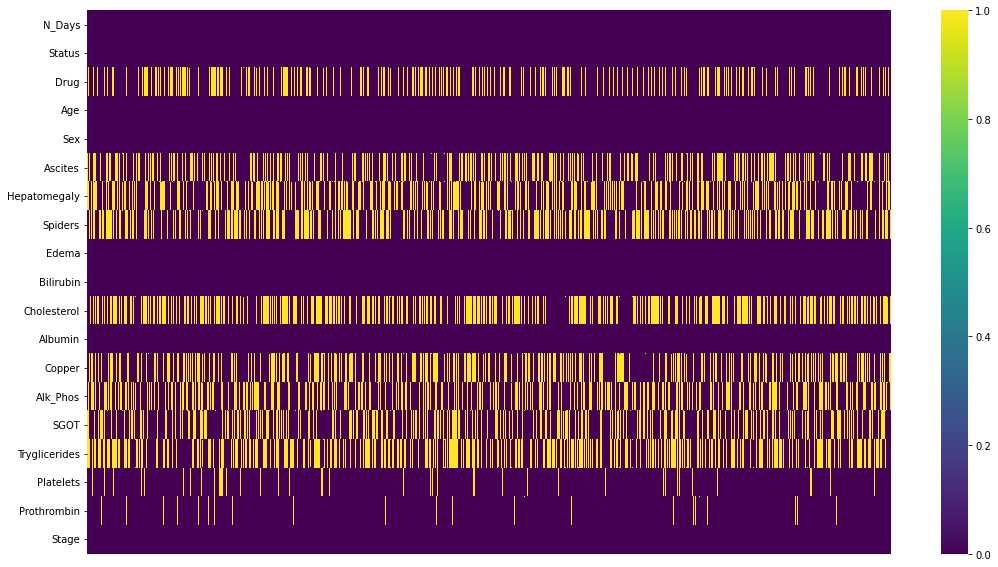

In [ ]:
plt.figure(figsize = (18,10))
sns.heatmap(train.isna().transpose(), xticklabels = False, cmap = 'viridis')
plt.show()

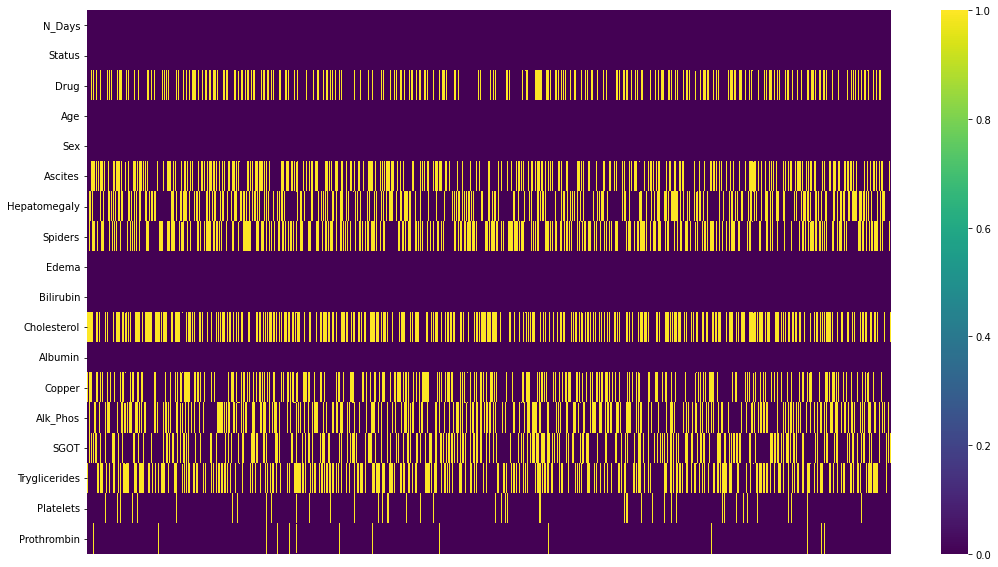

In [ ]:
plt.figure(figsize = (18,10))
sns.heatmap(test.isna().transpose(), xticklabels = False, cmap = 'viridis')
plt.show()

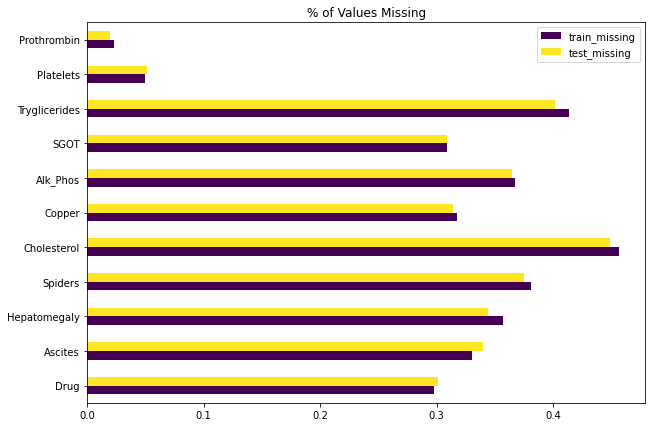

In [ ]:
ncounts = pd.DataFrame([train.isna().mean(), test.isna().mean()]).T
ncounts = ncounts.rename(columns = {0 : 'train_missing', 1 : 'test_missing'})

ncounts.query('train_missing > 0').plot(kind = 'barh', figsize = (10, 7), title = '% of Values Missing', cmap = 'viridis')
plt.show()

## Categorical to Numeric Vals

In [ ]:
def unique_val(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

In [ ]:
unique_val(train)

Status: ['CL' 'C' 'D']
Drug: ['D-penicillamine' nan 'Placebo']
Sex: ['F' 'M']
Ascites: ['N' nan 'Y']
Hepatomegaly: ['N' 'Y' nan]
Spiders: ['Y' nan 'N']
Edema: ['N' 'S' 'Y']


In [ ]:
train['Sex'].replace({'M': 0, 'F' : 1}, inplace = True)
train['Edema'].replace({'N': 0, 'S' : 1, 'Y' : 2}, inplace = True)
train['Status'].replace({'C' : 0, 'CL' : 1, 'D' : 2}, inplace = True)
train['Drug'].replace({'D-penicillamine' : 0, 'Placebo' : 1}, inplace = True)

In [ ]:
test['Sex'].replace({'M': 0, 'F' : 1}, inplace = True)
test['Edema'].replace({'N': 0, 'S' : 1, 'Y' : 2}, inplace = True)
test['Status'].replace({'C' : 0, 'CL' : 1, 'D' : 2}, inplace = True)
test['Drug'].replace({'D-penicillamine' : 0, 'Placebo' : 1}, inplace = True)

In [ ]:
numeric_val = ['Ascites', 'Hepatomegaly', 'Spiders']

for col in numeric_val:
    train[col].replace({'N': 0,'Y': 1}, inplace = True)
    test[col].replace({'N': 0,'Y': 1}, inplace = True)   

In [ ]:
train.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1654,1,0.000000,53.646575,1,0.000000,0.000000,1.000000,0,0.300000,279.000000,2.960000,84.000000,1500.800049,99.430000,109.000000,293.000000,10.200000,4.000000
1,41,0,0.000000,62.684932,1,NaN,0.000000,NaN,0,0.300000,NaN,2.960000,NaN,1835.400024,26.350000,131.000000,308.000000,10.800000,1.000000
2,297,2,NaN,76.594521,1,0.000000,0.000000,NaN,0,0.300000,328.000000,2.640000,4.000000,NaN,NaN,116.000000,194.000000,10.300000,3.000000
3,1872,0,0.000000,57.838356,1,NaN,1.000000,1.000000,0,0.300000,302.000000,2.020000,49.000000,NaN,26.350000,NaN,NaN,10.500000,4.000000
4,939,1,0.000000,49.482192,1,NaN,NaN,NaN,0,0.500000,344.000000,3.110000,91.000000,NaN,104.559998,NaN,306.000000,11.400000,2.000000


## Imputing Missing Vals using KNN Imputer

In [ ]:
features_train = ['N_Days', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 
            'Tryglicerides', 'Platelets', 'Prothrombin', 'Drug', 'Status', 'Stage']

In [ ]:
features_test = ['N_Days', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 
            'Tryglicerides', 'Platelets', 'Prothrombin', 'Drug', 'Status']

In [ ]:
from sklearn.impute import KNNImputer

knn_imptr = KNNImputer(n_neighbors = 1)
train_knnimp = knn_imptr.fit_transform(train[features_train])
train_imp = pd.DataFrame(train_knnimp, columns = features_train)


knn_train = pd.DataFrame(train_imp, columns = features_train)

In [ ]:
knn_train.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Drug,Status,Stage
0,1654.000000,53.646575,1.000000,0.000000,0.000000,1.000000,0.000000,0.300000,279.000000,2.960000,84.000000,1500.800049,99.430000,109.000000,293.000000,10.200000,0.000000,1.000000,4.000000
1,41.000000,62.684932,1.000000,0.000000,0.000000,1.000000,0.000000,0.300000,343.000000,2.960000,89.000000,1835.400024,26.350000,131.000000,308.000000,10.800000,0.000000,0.000000,1.000000
2,297.000000,76.594521,1.000000,0.000000,0.000000,1.000000,0.000000,0.300000,328.000000,2.640000,4.000000,1753.599976,117.940002,116.000000,194.000000,10.300000,1.000000,2.000000,3.000000
3,1872.000000,57.838356,1.000000,0.000000,1.000000,1.000000,0.000000,0.300000,302.000000,2.020000,49.000000,837.799988,26.350000,139.000000,79.000000,10.500000,0.000000,0.000000,4.000000
4,939.000000,49.482192,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,344.000000,3.110000,91.000000,1413.000000,104.559998,135.000000,306.000000,11.400000,0.000000,1.000000,2.000000


In [ ]:
from sklearn.impute import KNNImputer

knn_imptr = KNNImputer(n_neighbors = 1)
test_knnimp = knn_imptr.fit_transform(test[features_test])
test_imp = pd.DataFrame(test_knnimp, columns = features_test)


knn_test = pd.DataFrame(test_imp, columns = features_test)

In [ ]:
knn_test.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Drug,Status
0,41.000000,61.789041,1.000000,0.000000,1.000000,0.000000,0.000000,1.400000,247.000000,3.620000,23.000000,289.000000,108.650002,130.000000,169.000000,11.600000,1.000000,0.000000
1,1811.000000,44.446575,1.000000,0.000000,1.000000,0.000000,0.000000,0.300000,311.000000,2.800000,92.000000,1748.099976,112.190002,129.000000,321.000000,11.500000,0.000000,0.000000
2,954.000000,74.246575,1.000000,0.000000,0.000000,0.000000,0.000000,0.400000,162.000000,3.560000,20.000000,1370.900024,43.520000,73.000000,296.000000,10.300000,0.000000,0.000000
3,1969.000000,46.682192,1.000000,0.000000,1.000000,0.000000,0.000000,1.200000,372.000000,3.160000,95.000000,617.099976,113.760002,139.000000,125.000000,10.900000,1.000000,2.000000
4,2721.000000,48.597260,1.000000,1.000000,1.000000,0.000000,0.000000,3.200000,473.000000,2.360000,89.000000,1782.400024,40.639999,129.000000,138.000000,10.600000,0.000000,2.000000


In [ ]:
nacols = ['Prothrombin', 'Platelets', 'Tryglicerides', 'SGOT', 'Alk_Phos', 'Copper', 'Cholesterol', 'Spiders', 'Hepatomegaly', 'Ascites']

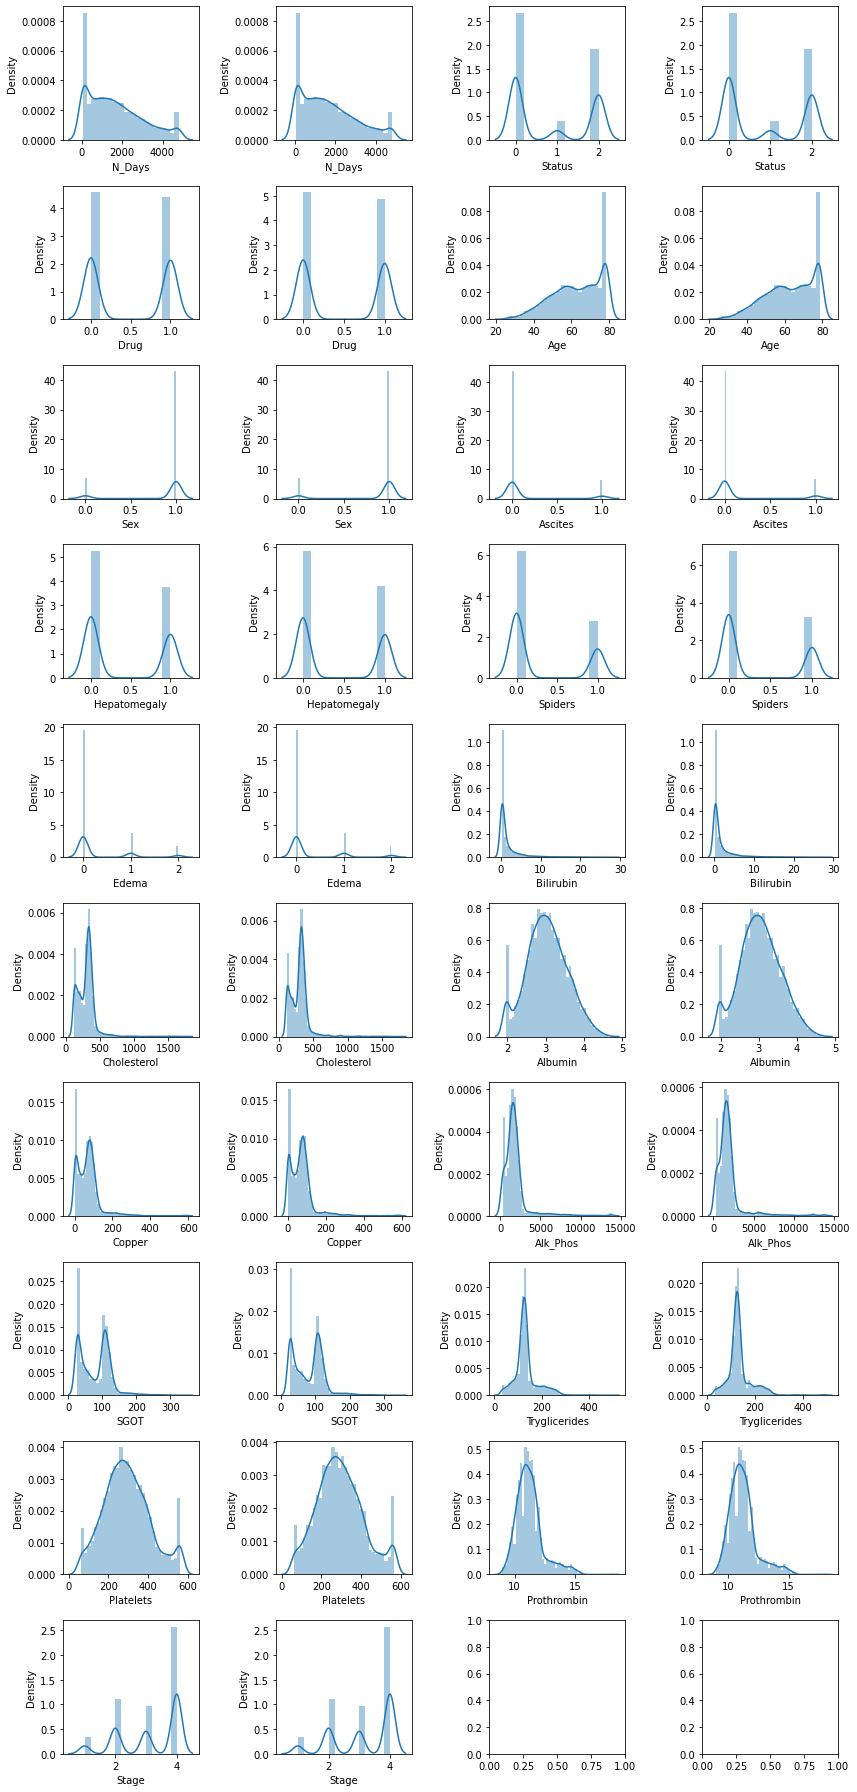

In [ ]:
fig, axes = plt.subplots(10, 4, figsize=(12, 25))
axes = axes.ravel()
k = 0
for i in train.columns  :
    if train[i].dtype == 'object':
        sns.countplot(train[i], ax = axes[k], axlabel = i)
        sns.countplot(knn_train[i], ax = axes[k+1], axlabel = i)
    else :
        sns.distplot(train[i], ax = axes[k], axlabel = i)
        sns.distplot(knn_train[i], ax = axes[k+1], axlabel = i)
    k += 2

fig.tight_layout()

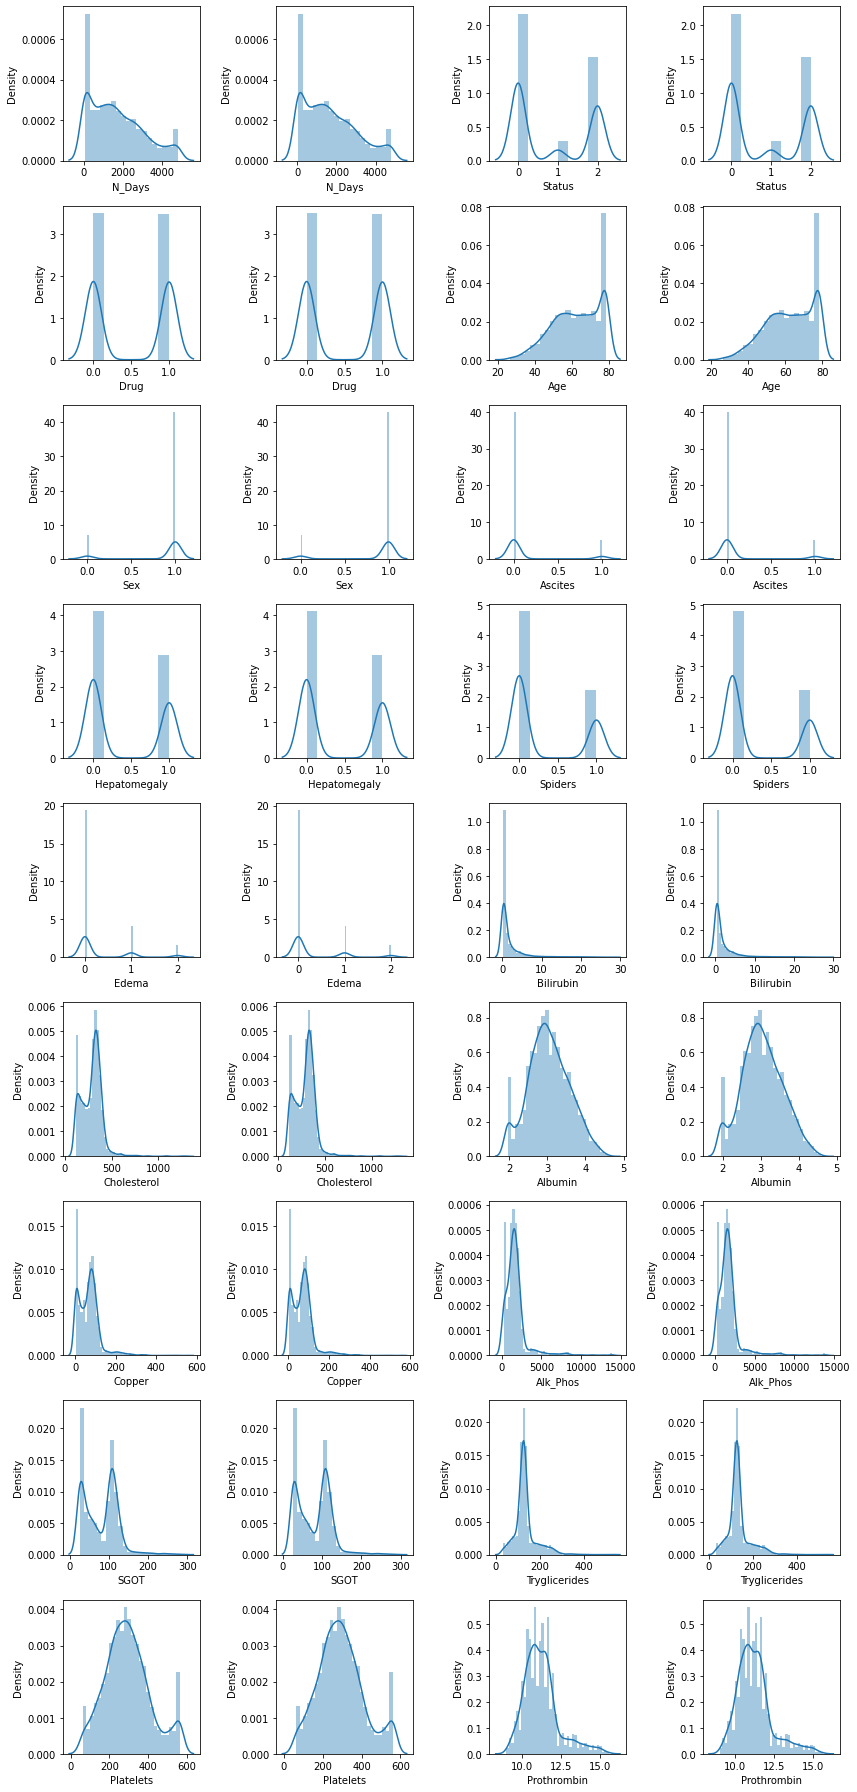

In [ ]:
fig, axes = plt.subplots(9, 4, figsize=(12, 25))
axes = axes.ravel()
k = 0
for i in test.columns  :
    if test[i].dtype == 'object':
        sns.countplot(test[i], ax = axes[k], axlabel = i)
        sns.countplot(knn_test[i], ax = axes[k+1], axlabel = i)
    else :
        sns.distplot(test[i], ax = axes[k], axlabel = i)
        sns.distplot(test[i], ax = axes[k+1], axlabel = i)
    k += 2

fig.tight_layout()

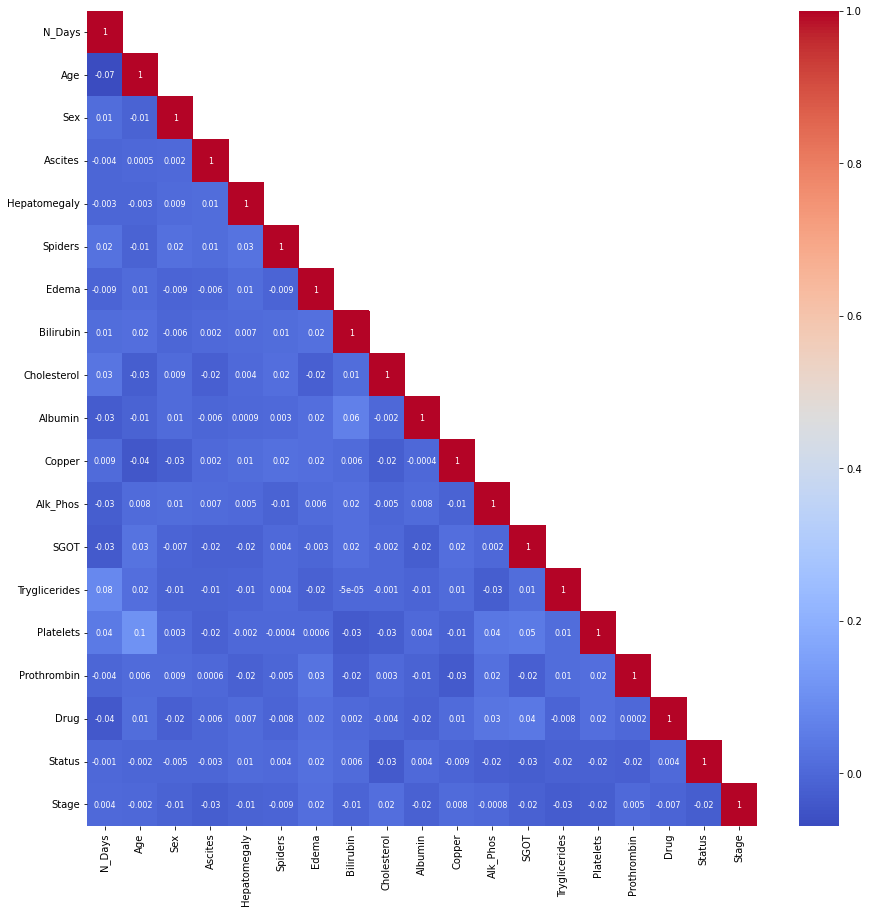

In [ ]:
plt.figure(figsize = (15, 15)) # Getting the Upper Triangle of the co-relation matrix 
corr = knn_train.corr() 
corr = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
sns.heatmap(corr, annot=True, annot_kws={"size": 8}, cmap="coolwarm", fmt='.1g');

## Outlier removal

In [ ]:
from scipy import stats
knn_train_copy = knn_train[(np.abs(stats.zscore(knn_train)) < 3).all(axis=1)]

In [ ]:
knn_test_copy = knn_test[(np.abs(stats.zscore(knn_test)) < 3).all(axis=1)]

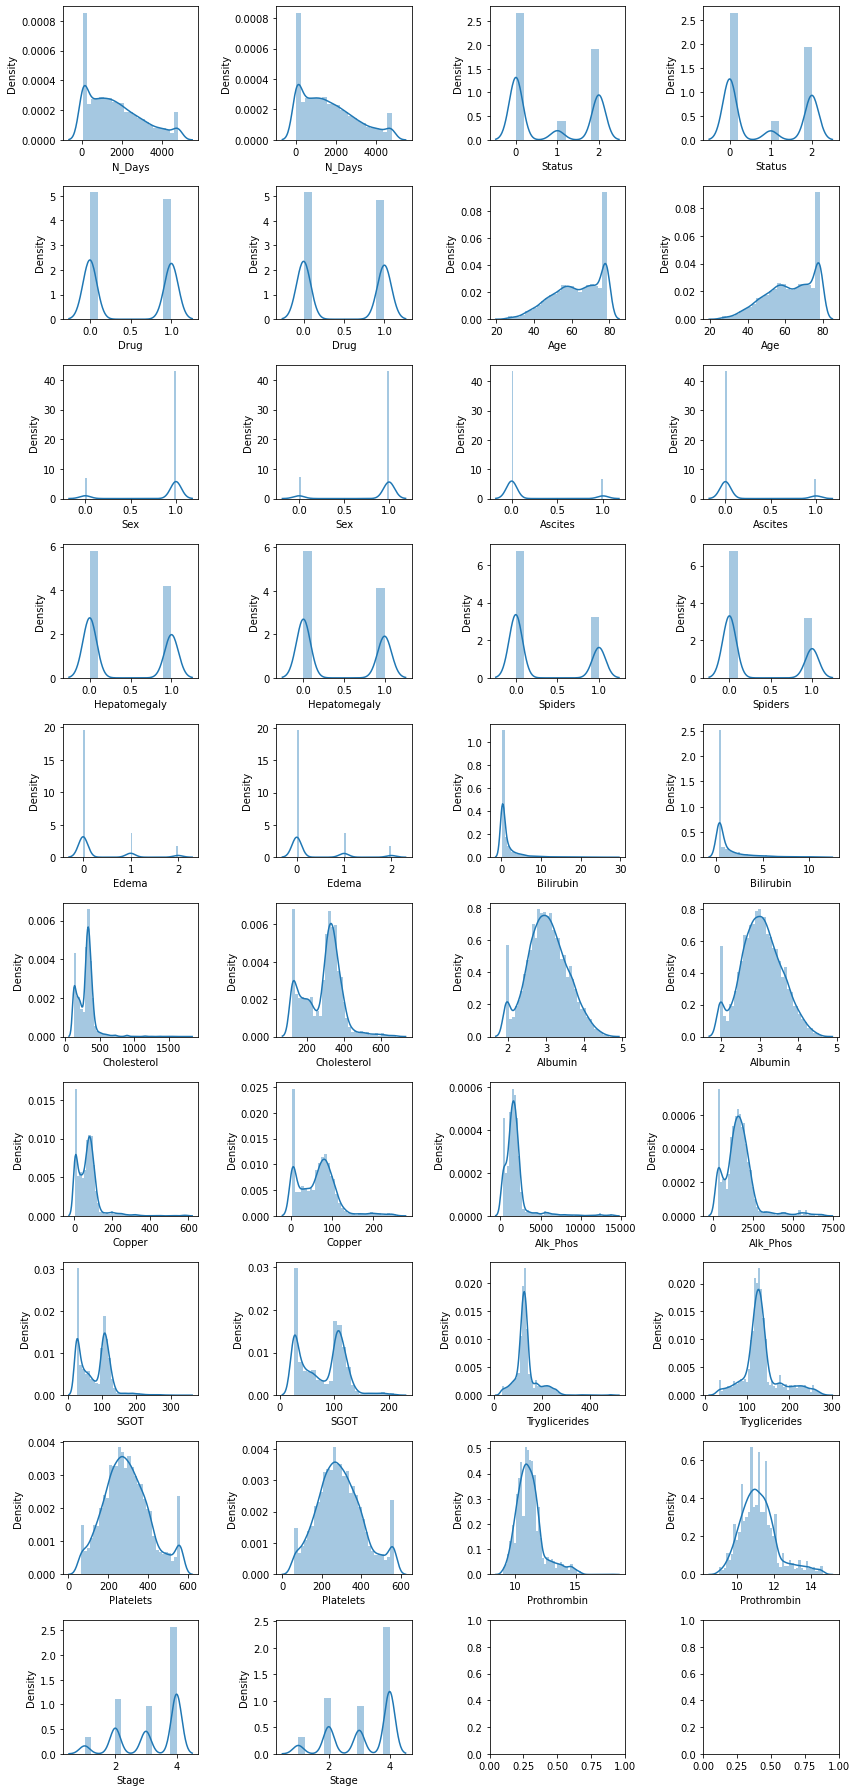

In [ ]:
fig, axes = plt.subplots(10, 4, figsize=(12, 25))
axes = axes.ravel()
k = 0
for i in train.columns  :
    if train[i].dtype == 'object':
        sns.countplot(knn_train[i], ax = axes[k], axlabel = i)
        sns.countplot(knn_train_copy[i], ax = axes[k+1], axlabel = i)
    else :
        sns.distplot(knn_train[i], ax = axes[k], axlabel = i)
        sns.distplot(knn_train_copy[i], ax = axes[k+1], axlabel = i)
    k += 2

fig.tight_layout()

## Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
train_impute = knn_train_copy.drop(['Stage'], axis = 1)

In [ ]:
knn_train_copy.isna().sum()

N_Days           0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Drug             0
Status           0
Stage            0
dtype: int64

In [ ]:
knn_train.columns == features_train

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
train_df = pd.DataFrame(scalar.fit_transform(train_impute), columns = train_impute.columns)
train_df.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Drug,Status
0,0.339293,0.523987,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.282416,0.377358,0.320000,0.182324,0.399541,0.308943,0.461078,0.214286,0.000000,0.500000
1,0.000000,0.697145,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.396092,0.377358,0.340000,0.232667,0.000000,0.398374,0.491018,0.321429,0.000000,0.000000
2,0.053849,0.963626,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.369449,0.256604,0.000000,0.220360,0.500738,0.337398,0.263473,0.232143,1.000000,1.000000
3,0.385149,0.604294,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.323268,0.022641,0.180000,0.082571,0.000000,0.430894,0.033932,0.267857,0.000000,0.000000
4,0.188894,0.444205,1.000000,0.000000,0.000000,0.000000,0.000000,0.018018,0.397869,0.433962,0.348000,0.169114,0.427587,0.414634,0.487026,0.428571,0.000000,0.500000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
test_df = pd.DataFrame(scalar.fit_transform(knn_test_copy), columns = knn_test_copy.columns)
test_df.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Drug,Status
0,0.000000,0.679981,1.000000,0.000000,1.000000,0.000000,0.000000,0.097345,0.255020,0.640927,0.085202,0.000000,0.446724,0.394309,0.213573,0.464286,1.000000,0.000000
1,0.372318,0.347733,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.383534,0.324324,0.394619,0.234236,0.465939,0.390244,0.516966,0.446429,0.000000,0.000000
2,0.192049,0.918644,1.000000,0.000000,0.000000,0.000000,0.000000,0.008850,0.084337,0.617761,0.071749,0.173682,0.093199,0.162602,0.467066,0.232143,0.000000,0.000000
3,0.405553,0.390563,1.000000,0.000000,1.000000,0.000000,0.000000,0.079646,0.506024,0.463320,0.408072,0.052671,0.474461,0.430894,0.125749,0.339286,1.000000,1.000000
4,0.563736,0.427252,1.000000,1.000000,1.000000,0.000000,0.000000,0.256637,0.708835,0.154440,0.381166,0.239742,0.077566,0.390244,0.151697,0.285714,0.000000,1.000000


In [ ]:
train_df.shape, knn_train_copy.shape

((6049, 18), (6049, 19))

In [ ]:
train_df["Stage"] = knn_train_copy["Stage"]. values

In [ ]:
train_df.shape

(6049, 19)

In [ ]:
X = train_df.drop(['Stage'], axis = 1)
y = train_df.Stage

In [ ]:
X.columns

Index(['N_Days', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Drug', 'Status'],
      dtype='object')

#Model

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_params = {
    'objective' : 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 4,
    'n_estimators' : 50,
    "learning_rate" : 0.128,
}

In [ ]:
xgb_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y-1)):
    
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train , y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict(X_valid)
    f1 = f1_score(list(y_valid.values),  list(preds_valid), average = "weighted")
    xgb_scores.append(f1)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, f1 score: {f1:.2f}, Run Time: {run_time:.2f}s")

    
print("Mean f1 :", np.mean(xgb_scores))